In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats
from numpy import mean

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes (tables) that automap found 
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table in hawaii.sqlite
MS = Base.classes.measurement
ST = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# View database
session.query(MS, ST).all()

[(<sqlalchemy.ext.automap.measurement at 0x294ef3da3a0>,
  <sqlalchemy.ext.automap.station at 0x294f63bfe20>),
 (<sqlalchemy.ext.automap.measurement at 0x294ef3da3a0>,
  <sqlalchemy.ext.automap.station at 0x294f63bfeb0>),
 (<sqlalchemy.ext.automap.measurement at 0x294ef3da3a0>,
  <sqlalchemy.ext.automap.station at 0x294f63bff10>),
 (<sqlalchemy.ext.automap.measurement at 0x294ef3da3a0>,
  <sqlalchemy.ext.automap.station at 0x294f63bff70>),
 (<sqlalchemy.ext.automap.measurement at 0x294ef3da3a0>,
  <sqlalchemy.ext.automap.station at 0x294f63bffa0>),
 (<sqlalchemy.ext.automap.measurement at 0x294ef3da3a0>,
  <sqlalchemy.ext.automap.station at 0x294f63c3070>),
 (<sqlalchemy.ext.automap.measurement at 0x294ef3da3a0>,
  <sqlalchemy.ext.automap.station at 0x294f63c3100>),
 (<sqlalchemy.ext.automap.measurement at 0x294ef3da3a0>,
  <sqlalchemy.ext.automap.station at 0x294f63c3190>),
 (<sqlalchemy.ext.automap.measurement at 0x294ef3da3a0>,
  <sqlalchemy.ext.automap.station at 0x294f63c3220>),
 

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
# desc is descending and first is the first response
session.query(MS.date).order_by(MS.date.desc()).first()

('2017-08-23')

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
year_date = dt.date(2017,8,23)- dt.timedelta(days=365)
print("date :", year_date)

# Perform a query to retrieve the data and precipitation scores
annual_rain = session.query(MS.date, MS.prcp).filter(MS.date >= year_date).all()
annual_rain

# Save the query results as a Pandas DataFrame and set the index to the date column
rain = pd.DataFrame(annual_rain, columns=['Date', 'Prcp'])
rain.set_index('Date', inplace=True)

# Sort the dataframe by date
rain.sort_index()

date : 2016-08-23


,Prcp
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


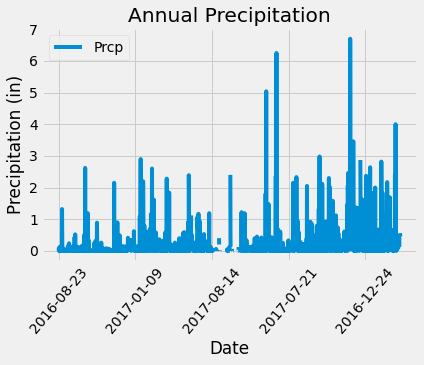

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
rain.plot(rot = 50, title='Annual Precipitation')
plt.ylabel('Precipitation (in)')
plt.tight_layout
plt.savefig("Images/Annual_Precipitation.png")
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain.describe()

,Prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(ST.station).group_by(ST.id).count()
print(f"The total number stations in the dataset is: {station_count}")

The total number stations in the dataset is: 9


In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)

# List the stations and the counts in descending order.
active =session.query(MS.station).group_by(MS.station).\
    order_by(func.count(MS.date).desc()).first()
most_active= active[0]
most_active

# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature
print(f"The station id of the most active station is {most_active}.")

The station id of the most active station is USC00519281.


In [16]:
# Statistical analysis of the most active station
session.query(func.min(MS.tobs), func.max(MS.tobs), func.avg(MS.tobs)).\
filter(MS.station == most_active) .\
all()

print(f'''
--------------------------------------------------------------------
The lowest temperature recorded at the most active station is: 54.
The highest temperature recorded at the most active station is: 85.
The average temperature recorded at the most active station is: 72. 
---------------------------------------------------------------------
''')


--------------------------------------------------------------------
The lowest temperature recorded at the most active station is: 54.
The highest temperature recorded at the most active station is: 85.
The average temperature recorded at the most active station is: 72. 
---------------------------------------------------------------------



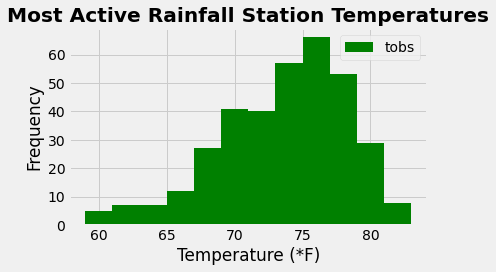

<Figure size 432x288 with 0 Axes>

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_active= session.query(MS.tobs).filter(MS.station == most_active).\
    filter(MS.date>=year_date).all()
#temp_active.head() 

#Make a dataframe bc temp_active is a tuple ('list' object)
temp_df = pd.DataFrame(temp_active, columns=["tobs"])
#temp_df.head()

#temp_active
plt.hist(temp_df["tobs"], color ='green', bins=12)
plt.ylabel("Frequency")
plt.xlabel('Temperature (*F)')
plt.title('Most Active Rainfall Station Temperatures',
          fontweight ="bold")
plt.legend(["tobs"])
plt.tight_layout()
plt.show()

# Save the plot
plt.savefig("Images/Most_Active_Histogram.png")


# Bonus Section- Temperature Analysis I

# Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

In [18]:
# Use pandas to: Convert the date column format from string to datetime, Set the date column as the DataFrame index, and Drop the date column

# Compute the June and Dec avg temps
# June in func.strftime is 06 and Dec is 12
june = session.query(MS.tobs).filter(func.strftime('%m', MS.date) == '06').all()
june = [t[0] for t in june]
avg_june_temp = round(mean(june), 1)

dec = session.query(MS.tobs).filter(func.strftime('%m', MS.date) == '12').all()
dec = [t[0] for t in dec]
avg_dec_temp = round(mean(dec), 1)

In [19]:
# Print the June and Dec avg temps
print(f"Mean temperature in June: {avg_june_temp}")
print(f"Mean temperature in December: {avg_dec_temp}")

Mean temperature in June: 74.9
Mean temperature in December: 71.0


In [20]:
# Use the t-test to determine whether the difference in the means is statistically significant. 
# Use an ind ttest bc the two data sets aren't the same
print(stats.ttest_ind(june, dec))
print(f'''
----------------------------------------------------------------------------------------------------------------------------
pvalue is <.05 so we reject the null and accept the alternate hypthesis that the temps in June and December are different.
----------------------------------------------------------------------------------------------------------------------------''')


Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

----------------------------------------------------------------------------------------------------------------------------
pvalue is <.05 so we reject the null and accept the alternate hypthesis that the temps in June and December are different.
----------------------------------------------------------------------------------------------------------------------------


# Bonus Section- Temperature Analysis II

# See what weather was like for your trip you are planning

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    Returns:
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(MS.tobs), func.avg(MS.tobs), func.max(MS.tobs)).\
        filter(MS.date >= start_date).filter(MS.date <= end_date).all()

# For example
print(calc_temps('2017-08-01', '2017-08-07'))

[(72.0, 79.25, 83.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using data for August 1-7.
trip_temp = calc_temps('2017-08-01', '2017-08-07')
# 0 is min, 1 is average (round), 2 is max
trip_temp = [trip_temp[0][0], trip_temp[0][1], trip_temp[0][2]]
trip_temp[1] = round(trip_temp[1],1)
print(trip_temp)

[72.0, 79.2, 83.0]


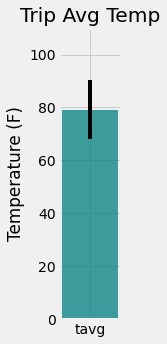

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2,5))
plt.bar(height = trip_temp[1], x = 'tavg', width = 0.1, yerr = (trip_temp[2]-trip_temp[0]), color = 'teal', alpha=0.75)
plt.title("Trip Avg Temp")
plt.ylabel("Temperature (F)")
plt.ylim(0,110)
plt.tight_layout()

# Save the plot
plt.savefig("Images/Trip Avg Temp.png")


# Daily Rainfall Average

In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
session.query(MS.station, ST.name, ST.latitude, ST.longitude, ST.elevation,
                func.sum(MS.prcp)).\
                filter(MS.date >= '2017-08-01').\
                filter(MS.date <= '2017-08-07').\
                group_by(MS.station).\
                order_by(func.sum(MS.prcp).desc()).\
                filter(MS.station == ST.station).all()

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  0.36),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.22),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.06),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.04),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.0)]

In [25]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(MS.tobs), func.avg(MS.tobs), func.max(MS.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", MS.date) == date).all()

# For example
daily_normals("08-08")

[(68.0, 76.5576923076923, 83.0)]

In [26]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals=[]
# Set the start and end date of the trip
start = dt.date(2017,8,1)
end = dt.date(2017,8,8)

# Use the start and end date to create a range of dates
trip_dates1 = [(start + dt.timedelta(days=x)) for x in range((end-start).days+1)]

# Strip off the year and save a list of strings in the format %m-%d
trip_dates2 = [d.strftime('%m-%d') for d in trip_dates1]

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
for day in trip_dates2:
    normals.append([daily_normals(day)[0][0], daily_normals(day)[0][1], daily_normals(day)[0][2]])

for t in np.arange(0, len(normals)):
    normals[t][1] = round(normals[t][1], 1)

normals

[[67.0, 75.5, 83.0],
 [68.0, 75.6, 84.0],
 [70.0, 76.6, 85.0],
 [69.0, 76.7, 84.0],
 [69.0, 76.1, 82.0],
 [67.0, 76.2, 83.0],
 [71.0, 77.2, 83.0],
 [68.0, 76.6, 83.0]]

In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
    
Hawaii_normals = pd.DataFrame(normals, columns=['temp_min', 'temp_avg', 'temp_max'])
Hawaii_normals['date'] = trip_dates1
Hawaii_normals.set_index('date', inplace=True)
Hawaii_normals.head(10)

,temp_min,temp_avg,temp_max
date,,,
2017-08-01,67.0,75.5,83.0
2017-08-02,68.0,75.6,84.0
2017-08-03,70.0,76.6,85.0
2017-08-04,69.0,76.7,84.0
2017-08-05,69.0,76.1,82.0
2017-08-06,67.0,76.2,83.0
2017-08-07,71.0,77.2,83.0
2017-08-08,68.0,76.6,83.0


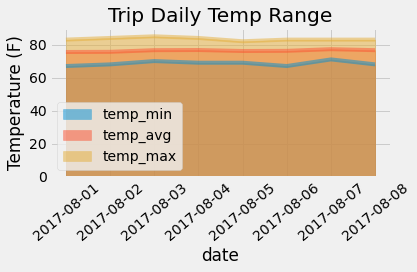

In [28]:
# Plot the daily normals as an area plot with `stacked=False`
Hawaii_normals.plot.area(stacked=False)
plt.title("Trip Daily Temp Range")
plt.ylabel("Temperature (F)")
plt.ylim(0,90)
plt.xticks(rotation=40)
plt.tight_layout()
# Save the plot
plt.savefig("Images/Trip Daily Temp Range.png")

# Close session

In [29]:
# Close Session
session.close()